# Advanced usage of the SHCoeffs and SHGrid class interfaces

*pyshtools* defines three major classes that simplify access to the underlying SHTOOLS functions:

* **SHCoeffs:** Spherical harmonic coefficients
* **SHGrid:** Gridded data on the sphere
* **SHWindows:** Multitaper windowing functions

The underlying data are stored in internal subclasses in different formats (such as `kind = 'real'` or `'complex'` and `grid = 'DH'` or `'GLQ'`). In this tutorial, we will demonstrate several aspects related to the `SHCoeffs` and `SHGrid` classes.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pyshtools as pysh

In [2]:
pysh.utils.figstyle(rel_width=0.75)
%config InlineBackend.figure_format = 'retina'  # if you are not using a retina display, comment this line

## Plot a single spherical harmonic function

The spherical harmonic coefficient class `SHCoeffs` can be initialized directly from a *numpy* array that holds the spherical harmonic coefficient data. Spherical harmonic coefficients are stored as a *numpy* array of dimension (2, lmax+1, lmax+1), where the first column corresponds to the cosine [0] and sine [1] components, the second column
corresponds to the spherical harmonic degree `l`, and the third column corresponds to the angular order `m`. We will first create a *numpy* array of coefficients that are equal to zero, with the exception of the `l=5`, `m=2` harmonic.

In [3]:
lmax = 200
coeffs = np.zeros((2, lmax+1, lmax+1))
coeffs[0, 5, 2] = 1.

To initialize a new class instance, we make use of the constructor method `from_array()`:

In [4]:
coeffs_l5m2 = pysh.SHCoeffs.from_array(coeffs)

When initializing a new class instance, the default is to assume that the input coefficients are 4$\pi$ normalized excluding the Condon-Shortley phase. This normalization convention can be overridden by setting the optional parameter `normalization`, which takes values of `'4pi'`, `'ortho'`, `'schmidt'`, or `'unnorm'`, along with the parameter `csphase`, which can be 1 (to exclude the Condon-Shortley phase) or -1 (to include it). The `SHCoeffs` class contains many methods, and here we use `plot_spectrum()` to plot the power spectrum: 

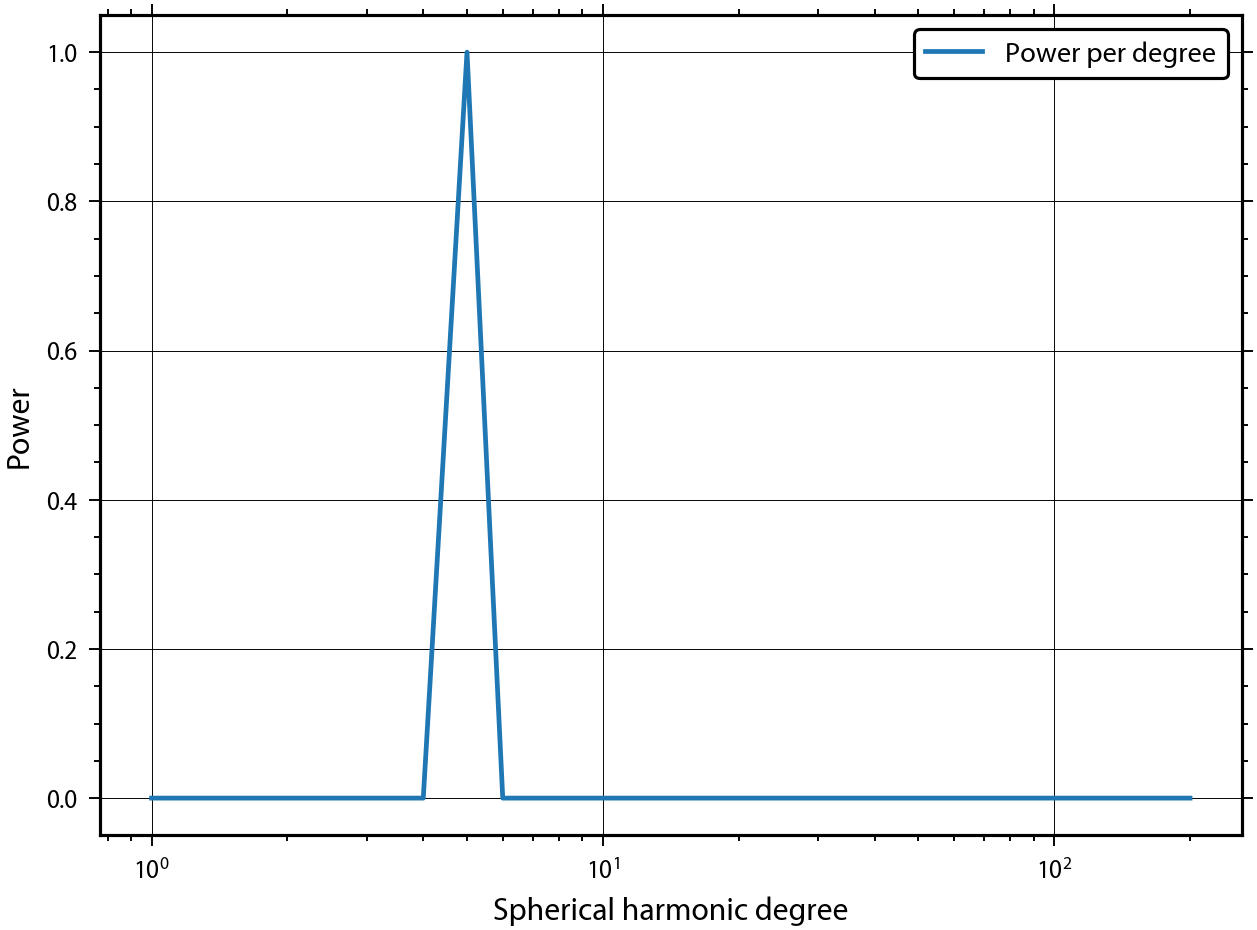

In [5]:
fig, ax = coeffs_l5m2.plot_spectrum(xscale='log', yscale='lin', show=False)    # show=False is used to avoid a warning when plotting in inline mode

To plot the function that corresponds to the coefficients, we first need to expand it on a grid, which can be accomplished using the `expand()` method:

In [6]:
grid_l5m2 = coeffs_l5m2.expand(grid='DH2')

This returns a new `SHGrid` class instance. The resolution of the grid is determined automatically to correspond to the maximum degree of the spherical harmonic coefficients in order to ensure good sampling. The optional parameter `grid` can be `'DH2'` for a Driscoll and Healy sampled grid with nlon = 2 * nlat, `'DH'` for a Driscol and Healy sampled grid with nlon = nlat, or `'GLQ'` for a grid used with the Gauss-Legendre quadrature expansion routines. Once the grid is created, it can be plotted using the built-in method `plot()`.

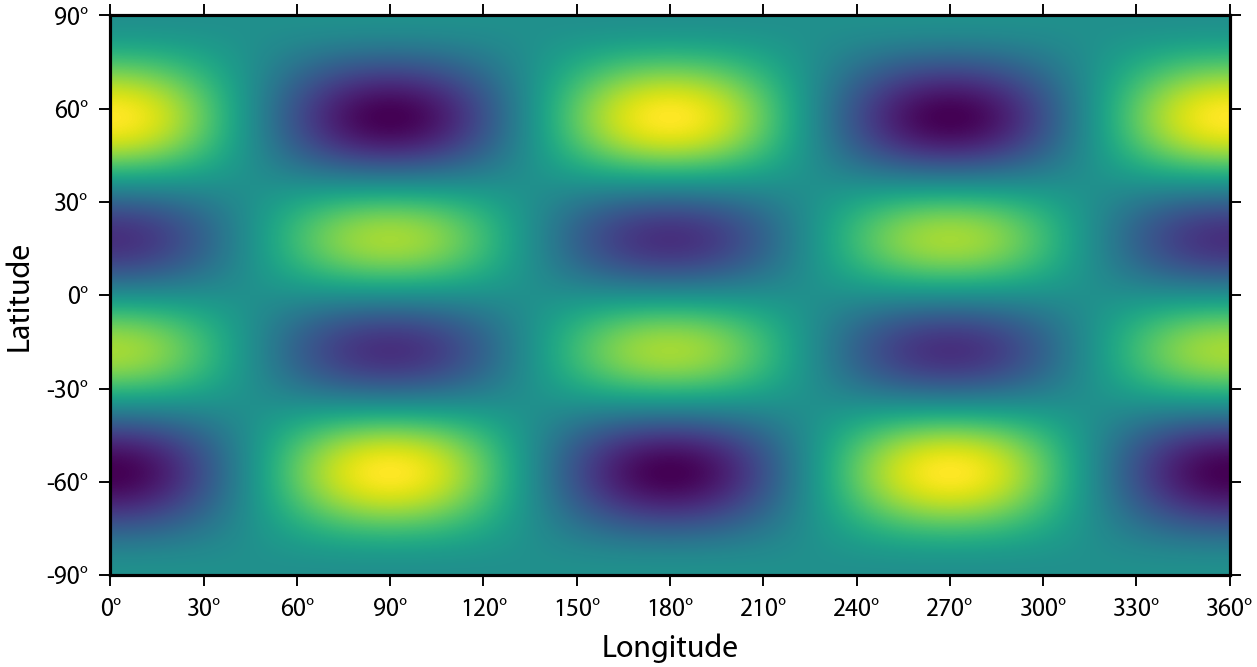

In [7]:
fig, ax = grid_l5m2.plot(show=False)

## Initialize with a random model

Another constructor for the `SHCoeffs` class is the `from_random()` method. It takes a power spectrum (power per degree l of the coefficients) and generates coefficients that are independent normal distributed random variables with the provided expected power spectrum. This corresponds to a stationary and isotropic random model on the surface of the sphere whose autocorrelation function is given by the spherical harmonic addition theorem.

We initialize coefficients here with a scale-free power spectrum that has equal band power beyond the scale length that defines the size of the largest model features. The particular property of this model is that it is invariant under zoom operations.

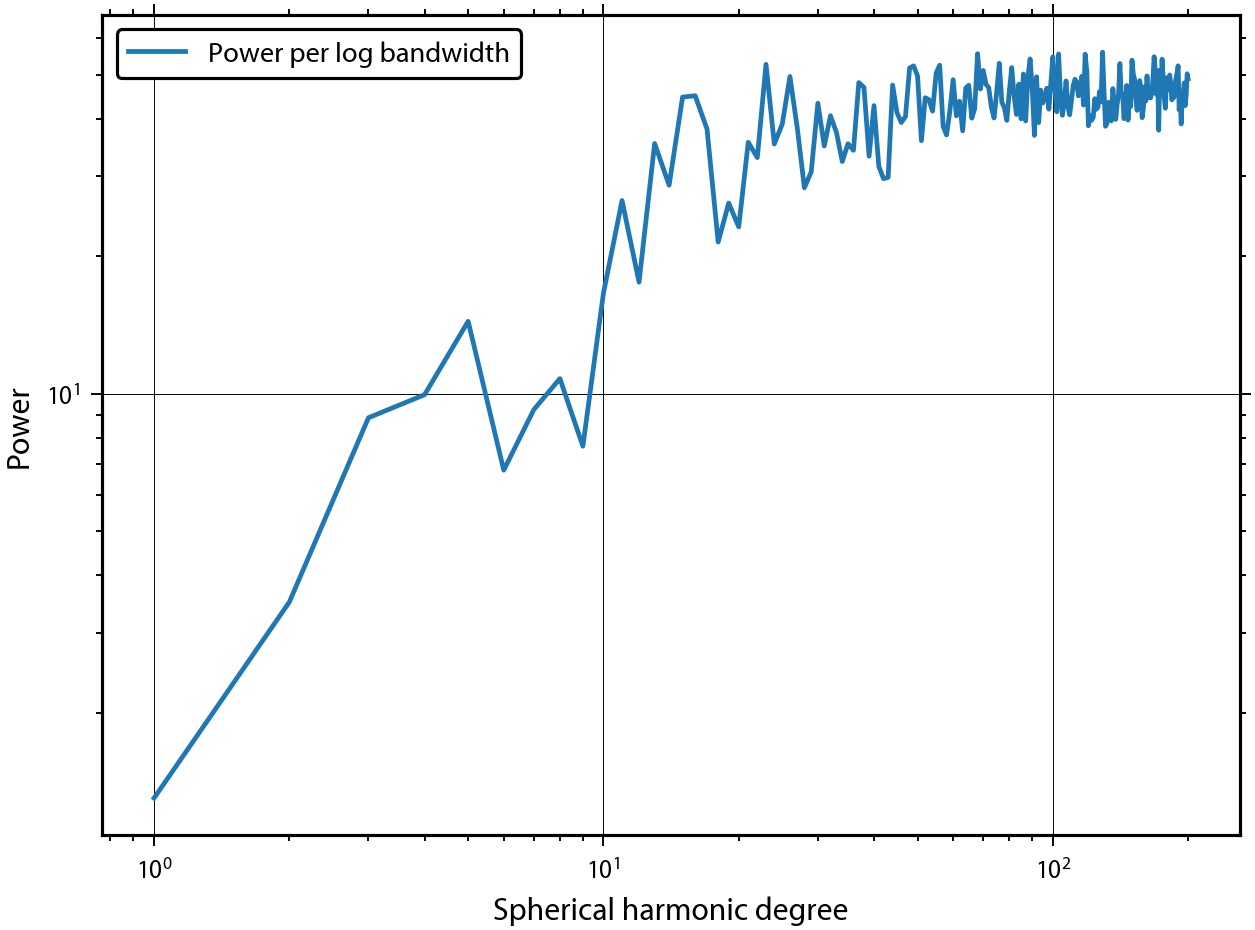

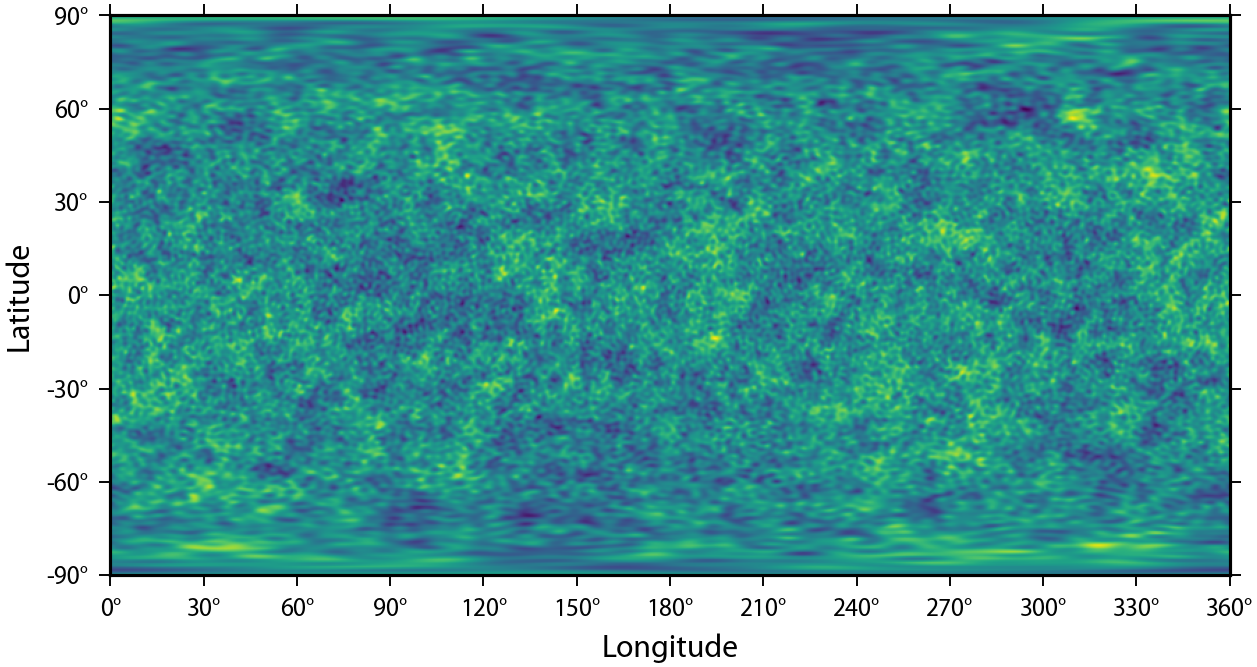

In [8]:
a = 20  # scale length
degrees = np.arange(lmax+1, dtype=float)
power = 1. / (1. + (degrees / a) ** 2) ** 0.5

coeffs_global = pysh.SHCoeffs.from_random(power)

fig, ax = coeffs_global.plot_spectrum(unit='per_dlogl', xscale='log', show=False)
fig2, ax2 = coeffs_global.expand(grid='DH2').plot(show=False)

## Rotating the coordinate system (or body)

Spherical harmonic coefficients can be expressed in a different coordinate system very efficiently. Importantly, the power per degree spectrum is invariant under rotation. 

The rotations are specified by the three Euler angles `alpha`, `beta`, and `gamma`. There are two different conventions for specifying these angles, and the rotations can furthermore be viewed as either a rotation of the coordinate system or a rotation of the physical body. pyshtools by default uses the "y-convention" and rotates the coordinate system with the following three successive operations

1. a rotation about the z axis by `alpha`,
2. a rotation about the new y axis by `beta`, and
3. a rotation about the new z axis by `gamma`.

To rotate the physical body instead of the coordinate system, it is only necessary to set the optional parameter `body` equal to True. To use the x convention, where the second rotation is with respect to the x axis, set the optional parameter `convention` equal to `'x'`.

In the following example, we use the constructor `from_zeros()`, and then use the method `set_coeffs()` to initialize a single zonal spherical harmonic coefficient. We then rotate the physical body whose symmetry axis passess through the north pole to 30 degrees east longitude on the equator.

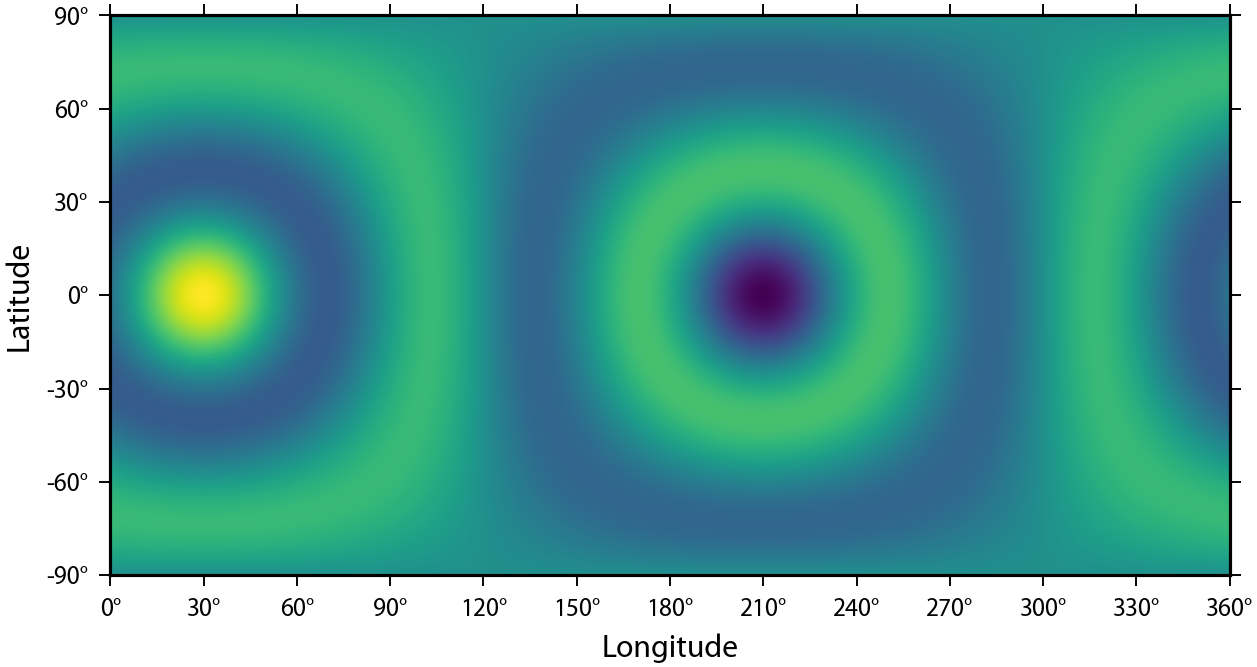

In [9]:
coeffs_l5m0 = pysh.SHCoeffs.from_zeros(lmax)
coeffs_l5m0.set_coeffs(1., 5, 0)

alpha = 30.  # rotation around the initial z-axis
beta = 90.  # rotation around the new y-axis
gamma = 0.  # rotation around the new z-axis

coeffs_l5m0_rot = coeffs_l5m0.rotate(alpha, beta, gamma, body=True, degrees=True)

grid_l5m0_rot = coeffs_l5m0_rot.expand(grid='DH2')
fig, ax = grid_l5m0_rot.plot(show=False)

## Arithmetic operations

Similar grids can be added, multiplied and subtracted using standard python operators. It is easily verified that the following sequence of operations return the same rotated grid as above:

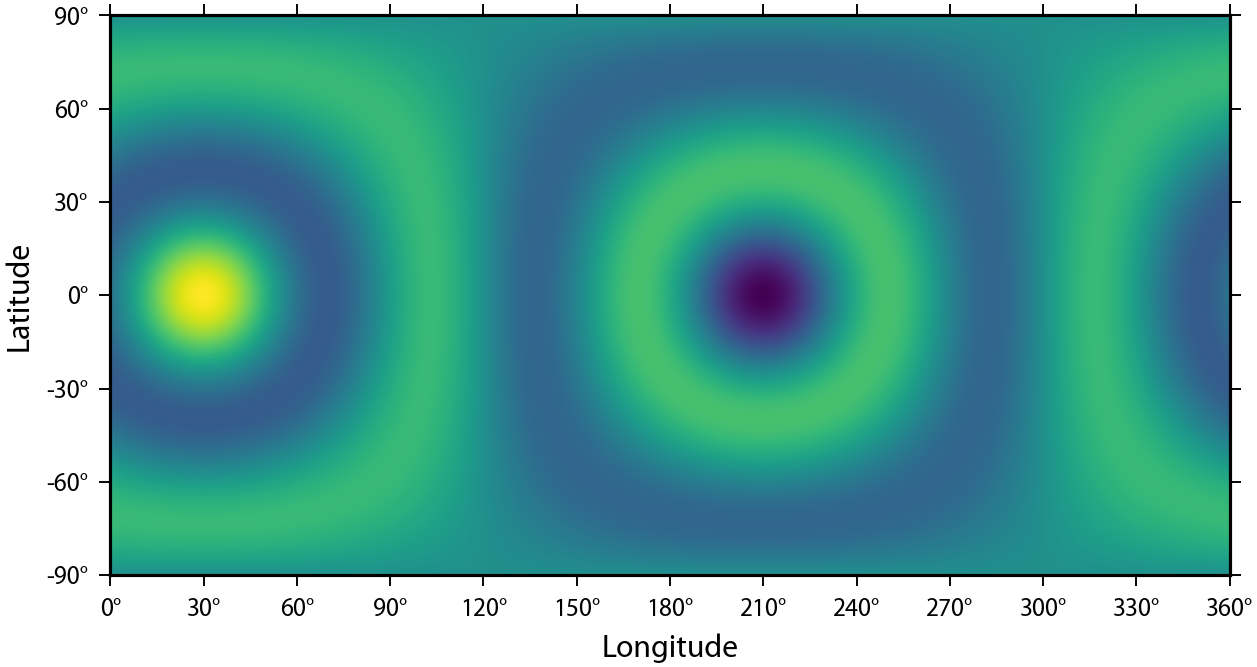

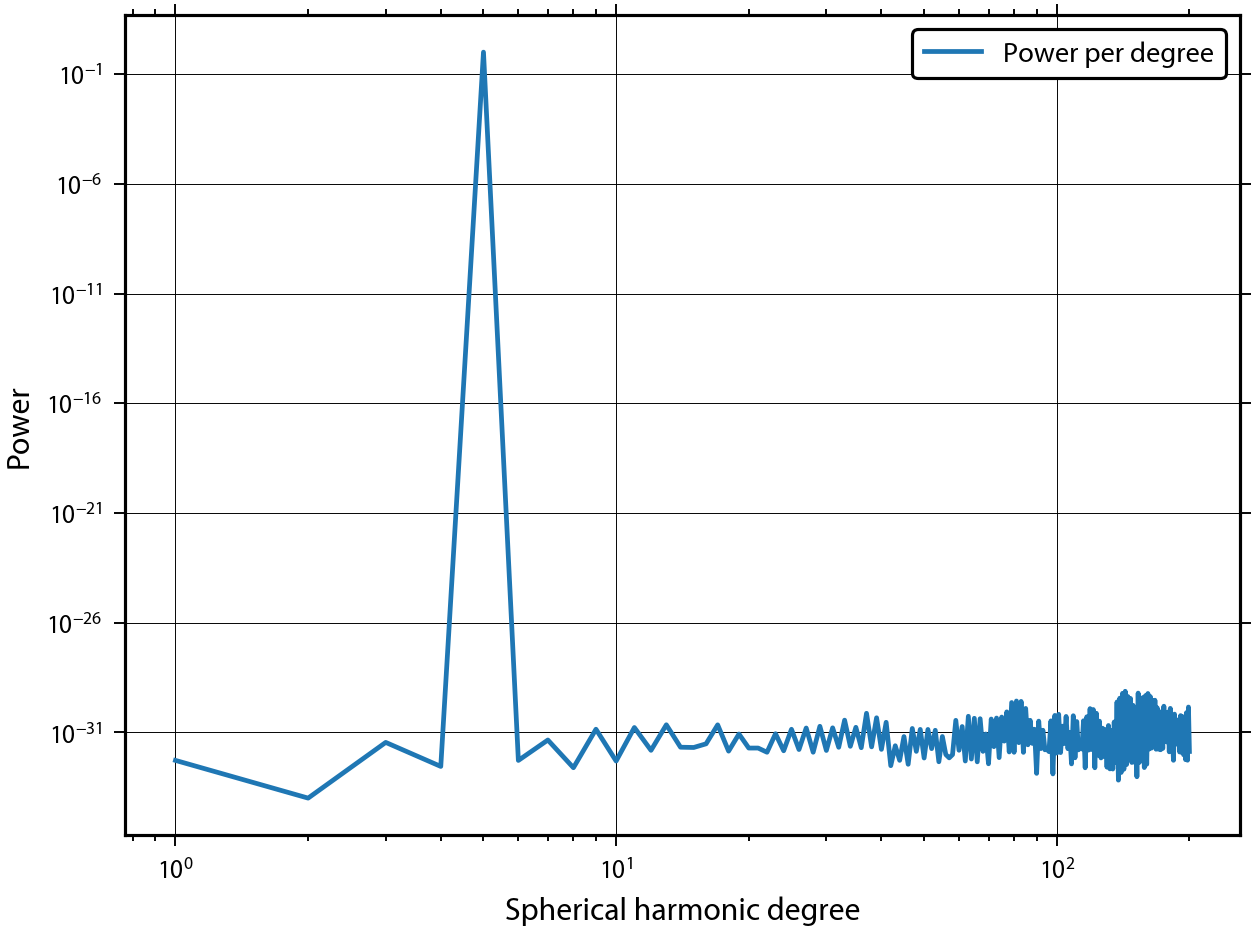

In [10]:
grid_new = (2. * grid_l5m0_rot + grid_l5m2**2 - grid_l5m2 * grid_l5m2) / 2.0
grid_new.plot(show=False)

coeffs = grid_new.expand()
fig, ax = coeffs.plot_spectrum(xscale='log', show=False)